## Import packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.python.client import timeline
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Import the MNIST dataset

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)
X_tr=mnist.train.images
Y_tr=mnist.train.labels
X_te=mnist.test.images
Y_te=mnist.test.labels
X_val=mnist.validation.images
Y_val=mnist.validation.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [10]:
np.shape(X_val)
np.shape(Y_val)

(5000, 10)

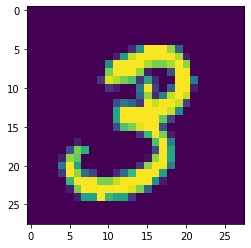

In [11]:
plt.imshow(np.reshape(X_tr[1,:],[28,28]))

## Apply permutation for the psMNIST

In [12]:
P=np.shape(X_tr)[1]
permutation=np.random.permutation(P)

X_tr=X_tr[:,permutation]
X_te=X_te[:,permutation]
X_val=X_val[:,permutation]

In [13]:
#io.savemat("X_tr_p.mat",{"array": X_tr})
#io.savemat("Y_tr_p.mat",{"array": Y_tr})

## Class to compute the ESN response

The input should be:
<ul>
    <li> alpha1, alpha2: leakage term of the reservoir 1 and 2 </li>
    <li> pho1, pho2: $\rho$ of the reservoir 1 and 2 </li>
    <li> diluition1, diluition2: probability of a zero in the connectivity matrix of ESN 1 and 2 </li> 
    <li> N1, N2: number of nodes of ESN 1 and 2 </li>
    <li> W1_in, W2_in: input connectivity matrix of ESN 1 and 2 </li>
    <li> gamma12: multiplicative factor of the connectivity matrix between the two ESN
    <li> T_conc: the multiples of T_conc define the values for the readout </li>
    
</ul>

Note: ESN 1 is the 'deeper' one and receives input from ESN 2 in the case of hierarchical structure

In [24]:
class Echo:
    
    def __init__(self,alpha1, pho1, diluition1, N1, W1_in,
                         alpha2, pho2, diluition2, N2, W2_in, gamma12, T_conc):
                
            ## Reservoir 1
        
            self.N1=N1
            
            ## alpha 1
            self.alpha1=tf.constant(alpha1,dtype=tf.float32)
            
            ## W1 def
            W1_np=np.random.uniform(-1,1,[N1,N1])
            D=np.random.uniform(0,1,(N1,N1))>np.ones((N1,N1))*diluition1
            W1_np=W1_np*D.astype(int)
            
            eig1=np.linalg.eigvals(W1_np)

            W1_np=pho1*W1_np/(np.max(np.absolute(eig1)))
            self.W1=tf.Variable(W1_np,trainable=False,dtype=tf.float32)
            
            
            self.eig1=eig1
            
            ## Input W
            self.W1_in=tf.Variable(W1_in,trainable=False,dtype=tf.float32)
            
            
            ## Reservoir 2
            
            self.N2=N2
            
            ## alpha 2
            self.alpha2=tf.constant(alpha2,dtype=tf.float32)
            
            ## W2 def
            W2_np=np.random.uniform(-1,1,[N2,N2])
            D=np.random.uniform(0,1,(N2,N2))>np.ones((N2,N2))*diluition2
            W2_np=W2_np*D.astype(int)

            eig2=np.linalg.eigvals(W2_np)
            
            W2_np=pho2*W2_np/(np.max(np.absolute(eig2)))
            self.W2=tf.Variable(W2_np,trainable=False,dtype=tf.float32)    
                     
            ## Input W    
            self.W2_in=tf.Variable(W2_in,trainable=False,dtype=tf.float32)
            
            ## Reservoir 2 to Reservoir 1
            
            W12=gamma12*np.random.randn(N2,N1)
            
            self.W12=tf.Variable(W12,trainable=False,dtype=tf.float32)
            
            ## The multiples of T_conc are the values of t at which the ESN representations are concatenated
            self.T_conc=T_conc
            
    def train_graph(self,T,init_state1,init_state2,inputs,return_all=False):

        
        state1=init_state1
        states_train1=[]
        
        state2=init_state2
        states_train2=[]

        
        
        for t in range(T):
            
            prev_state1=tf.identity(state1)
            prev_state2=tf.identity(state2)
            
            state1 = (1-self.alpha1)*prev_state1+self.alpha1*tf.tanh( tf.matmul(prev_state1,self.W1)\
                                                    
                                                                     +tf.matmul(prev_state2,self.W12)\
                                                                     
                                                                     +tf.tile(tf.expand_dims(inputs[:,t],1),[1,self.N1])*self.W1_in )
                                                    
           
            state2 = (1-self.alpha2)*prev_state2+self.alpha2*tf.tanh( tf.matmul(prev_state2,self.W2)\
                                                                     
                                                                     +tf.tile(tf.expand_dims(inputs[:,t],1),[1,self.N2])*self.W2_in )
            
            
            if return_all:
                
                states_train1.append(state1)
                
                states_train2.append(state2)
                
            elif (t+1)%self.T_conc==0:
                
                states_train1.append(state1)
                
                states_train2.append(state2)
                
                
        states1=tf.concat([tf.expand_dims(s,2) for s in states_train1],2)
        
        states2=tf.concat([tf.expand_dims(s,2) for s in states_train2],2)
        
        states=tf.concat([states1,states2],axis=1)
        
        return states, states1, states2
        
        

## Definition of the input connectivity matrices
In the case of hierarchical ESN, W1_In will be set to zero

In [20]:
def W_input(N1,N2):

    W1_In=np.ones(N1)
    W1_In[np.random.uniform(0,1,N1)<0.5]=-1
    
    W2_In=np.ones(N2)
    W2_In[np.random.uniform(0,1,N2)<0.5]=-1
    W2_In=W2_In 
    
    return W1_In, W2_In

## ESN representation over the dataset

The data are splitted because of the limited memory in my gpu

In [21]:
## ESN representation over the dataset
def Echo_representations(alpha1, pho1, diluition1, N1, W1_in,
                             alpha2, pho2, diluition2, N2, W2_in, gamma12, 
                             X_tr, X_val, X_test, T_size):

    T=np.shape(X_tr)[1]
    N_class=np.shape(Y_tr)[1]
    
    T_conc=np.int(T/T_size)
    
    rnn=Echo(alpha1, pho1, diluition1, N1, W1_in,
                alpha2, pho2, diluition2, N2, W2_in, gamma12, T_conc)

    init_state1=tf.placeholder(tf.float32,[None,N1])
    init_state2=tf.placeholder(tf.float32,[None,N2])
    s=tf.placeholder(tf.float32,[None,T])

    states, states1, states2=rnn.train_graph(T,init_state1,init_state2,s,return_all=False)

    init=tf.global_variables_initializer()

    train_divide=100
    N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

    test_divide=50
    N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))
    
    val_divide=50
    N_val_d=int(np.floor(np.shape(Y_val)[0]/val_divide))

    States=np.zeros([N_train_d*train_divide,N,T_size])
    States_test=np.zeros([N_test_d*test_divide,N,T_size])
    States_val=np.zeros([N_val_d*val_divide,N,T_size])

    with tf.Session() as sess:

        sess.run(init)
        
        print('Training Data')

        for l in range(train_divide):

            images=np.copy(X_tr[l*N_train_d:(l+1)*N_train_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_train_d,N1]),init_state2:np.zeros([N_train_d,N2]),s:images})

            States[l*N_train_d:(l+1)*N_train_d,:,:]=states_

            
        print('Testing Data')

        for l in range(test_divide):

            images=np.copy(X_te[l*N_test_d:(l+1)*N_test_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_test_d,N1]),init_state2:np.zeros([N_test_d,N2]),s:images})

            States_test[l*N_test_d:(l+1)*N_test_d,:,:]=states_    
            
       
        print('Validating Data')

        for l in range(val_divide):

            images=np.copy(X_val[l*N_val_d:(l+1)*N_val_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_val_d,N1]),init_state2:np.zeros([N_val_d,N2]),s:images})

            States_val[l*N_val_d:(l+1)*N_val_d,:,:]=states_
        
    
    return States, States_test, States_val


In [6]:
N_episodes=100000

N1=600
N2=600
N=N1+N2

alpha_size=0.0005

T_conc=28
N_class=np.shape(Y_tr)[1]

s=tf.placeholder(tf.float32,[None,N,T_conc])
V=tf.reshape(s,[-1,T_conc*N])

y_true=tf.placeholder(tf.float32,[None,N_class])

W_out=tf.Variable(np.random.uniform(-1,1,[N*T_conc,N_class])/(N),dtype=tf.float32)

y=tf.matmul(V,W_out)

error=tf.losses.sigmoid_cross_entropy(y_true,y)

train=tf.train.AdamOptimizer(learning_rate=alpha_size).minimize(error,var_list=[W_out])

batch_size=20            

NameError: name 'Y_tr' is not defined

In [27]:
from scipy import io

## Simulation 

init=tf.global_variables_initializer()

N_episodes=100000                      # Number of training iteration
alpha_size=0.0005                      # Learning rate
batch_size=20            
T_size=28                              # Number of hidden states used for the readout (they are equally spaced across the input sequence)

N_class=np.shape(Y_tr)[1]
N_size=np.shape(X_tr)[0]

N_check=15
T_checks=np.concatenate([np.linspace(10000,90000,5),np.linspace(91000,100000,N_check-5)],0)

# Number of times the test, validation and training dataset are divided
test_divide=2
val_divide=2
train_divide=10

N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))
N_val_d=int(np.floor(np.shape(Y_val)[0]/val_divide))
N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

N_grid=10                               # Number of values of alpha scanned in the loop

# Arrays to save the performance
p_ra_test=np.zeros([N_grid,N_grid,N_check])
p_ra_train=np.zeros([N_grid,N_grid,N_check])
p_ra_val=np.zeros([N_grid,N_grid,N_check])

## Network parameters

N1=600
N2=600
N=N1+N2

N1_av=5                                  # Average number of connections for a node in ESN 1
N2_av=3                                  # Average number of connections for a node in ESN 2

diluition1=1-N1_av/N1                    # Probability of a zero in the connectivity matrix of ESN 1
diluition2=1-N2_av/N2                    # Probability of a zero in the connectivity matrix of ESN 2

alpha1=np.exp(np.linspace(-5,0,N_grid))  # Values of alpha 1 scanned
alpha2=np.exp(np.linspace(-5,0,N_grid))  # Values of alpha 2 scanned


pho1=0.985                               # Value of \rho for ESN 1
pho2=1                                   # Value of \rho for ESN 2

# Connected=True will define a hierarchical structure where ESN 2 feeds into ESN 1
# Connected=False will define parallel ESNs
Connected=True
if Connected==True:
    
    gamma12=1 # Multiplicative factor of the connectivity between the reservoirs
    gamma1=0  # Multiplicative factor of the input connectivity to ESN 1

else:
    
    gamma12=0
    gamma1=1
    
## Training    
        
for i in range(2,N_grid):

    for j in range(6,7):
        
        tf.reset_default_graph()
        
        index_help=0

        W1_in,W2_in=W_input(N1,N2)
        W1_in=gamma1*W1_in.T

        print('Simulation ', i*N_grid+j, ', alpha1=',alpha1[i], ' alpha2=', alpha2[j])
        print('Processing Resrvoir Representations: ')

        States, States_test, States_val=Echo_representations(alpha1[i], pho1, diluition1, N1, W1_in,
                                 alpha2[j], pho2, diluition2, N2, W2_in, gamma12, 
                                 X_tr, X_val, X_te, T_size)

        print('Start Training: ')
        
        # Definition of the graph fpr the training
        # The placeholder s receives the representations of the ESN used for the readout (for the specific batch_size sequences considered) 
        s=tf.placeholder(tf.float32,[None,N,T_size])
        V=tf.reshape(s,[-1,T_size*N])

        y_true=tf.placeholder(tf.float32,[None,N_class])

        W_out=tf.Variable(np.random.uniform(-1,1,[N*T_size,N_class])/(N),dtype=tf.float32)

        y=tf.matmul(V,W_out)

        error=tf.losses.sigmoid_cross_entropy(y_true,y)

        train=tf.train.AdamOptimizer(learning_rate=alpha_size).minimize(error,var_list=[W_out])
        
        init=tf.global_variables_initializer()

        with tf.Session() as sess:
            sess.run(init)

            for n in range(N_episodes):

                if n>0:

                    rand_ind=np.random.randint(0,N_size,(batch_size,))

                    images=States[rand_ind,:,:]

                    labels=Y_tr[rand_ind,:]

                    _=sess.run(train,feed_dict={y_true:labels,s:images})

                # If the following condition is true, the program will compute the performance over the test and validation data
                if n==T_checks[index_help]:

                    index_help=index_help+1

                    matches=tf.equal(tf.argmax(y_true,1),tf.argmax(y,1))
                    p=tf.reduce_mean(tf.cast(matches,tf.float32))
    
                    # Performance on the test data, computed as a mean over the different splits of the dataset through the variable p_ra_ and error_ 
                    p_ra_=0
                    error_=0

                    for l in range(test_divide):

                        images=States_test[l*N_test_d:(l+1)*N_test_d,:,:]
                        labels=Y_te[l*N_test_d:(l+1)*N_test_d,:]

                        p_ra1_,error1_=sess.run([p,error],feed_dict={y_true:labels,s:images})

                        p_ra_=p_ra_+p_ra1_/test_divide
                        error_=error_+error1_/test_divide


                    p_ra_test[i,j,index_help]=p_ra_

                    #print('Iteration: ',n,'Reservoir ',i,'Probability: ',p_ra_,'Error: ',error_)

                    # Performance on the validation data, computed as a mean over the different splits of the dataset through the variable p_ra_ and error_ 
                    p_ra_v=0
                    error_v=0

                    for l in range(val_divide):

                        images=States_val[l*N_val_d:(l+1)*N_val_d,:,:]
                        labels=Y_val[l*N_val_d:(l+1)*N_val_d,:]

                        p_ra3_,error3_=sess.run([p,error],feed_dict={y_true:labels,s:images})

                        p_ra_v=p_ra_v+p_ra3_/val_divide
                        error_v=error_v+error3_/val_divide

                    p_ra_val[i,j,index_help]=p_ra_v

                    print('Iteration: ',n,'Reservoir ',i,'Probability: ',p_ra_v,'Error: ',error_v)


            #io.savemat("Acc_test_check"+repr(i)+"_"+repr(j)+".mat",{"array": p_ra_test[i,j,:]})
            #io.savemat("Acc_val_check"+repr(i)+"_"+repr(j)+".mat",{"array": p_ra_val[i,j,:]})


Simulation  26 , alpha1= 0.020468075714350484  alpha2= 0.18887560283756186
Processing Resrvoir Representations: 
Training Data
Testing Data
Validating Data
Start Training: 
Iteration:  10000 Reservoir  2 Probability:  0.8095999956130981 Error:  0.1540822833776474
Iteration:  30000 Reservoir  2 Probability:  0.8583999872207642 Error:  0.1325637400150299
Iteration:  50000 Reservoir  2 Probability:  0.9112000167369843 Error:  0.08820458501577377
Iteration:  70000 Reservoir  2 Probability:  0.8930000066757202 Error:  0.11839304864406586
Iteration:  90000 Reservoir  2 Probability:  0.9127999842166901 Error:  0.08123615756630898
Iteration:  91000 Reservoir  2 Probability:  0.8774000108242035 Error:  0.11494030430912971
Iteration:  92000 Reservoir  2 Probability:  0.883400022983551 Error:  0.1177138239145279
Iteration:  93000 Reservoir  2 Probability:  0.9214000105857849 Error:  0.07580337300896645
Iteration:  94000 Reservoir  2 Probability:  0.9093999862670898 Error:  0.08612212538719177
Ite

KeyboardInterrupt: 